# Solve *Easy21* by Deep Q-Network


In [1]:
import itertools
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

sns.set()
%matplotlib inline

In [2]:
from plot_utils import draw_heatmap
from dp_tools import mean_policy_value
from easy21 import Easy21, HIT, STICK

env = Easy21()

## Deep Q-network with experience replay and target network

1. Initialize Q-function $Q(s, a; \theta)$. Initialize replay buffer. Initialize the target Q-function $Q\left(s, a; \tilde{\theta}\right)$ with $\tilde{\theta} = \theta$ as a copy of the Q-function.
1. Set $t=0$ and initialize $s_t$
1. Choose action $a_t$ from exploration policy with the current $Q$ function.
1. Take $a_t$ and observe $(s_{t+1}, r_{t+1})$.
1. Push $(s_t, a_t, r_{t+1}, s_{t+1})$ to the replay buffer.
1. Extract a batch of $(s_i, a_i, r_i, s_i')$ from the replay buffer.
1. For each batch sample, compute the TD target as $v_i \leftarrow r_i + \gamma Q\left(s'_i, a'_i, \tilde{\theta} \right)$, where $a'_i = \mathrm{arg}\max_a Q(s'_i, a; \theta)$.
1. For each batch sample, compute the TD error as $\delta_i \leftarrow v_i - Q(s_i, a_i; \theta)$.
1. Update $\theta$ by:
$$
\theta \leftarrow \theta + \alpha \frac{\sum_{i=1}^{n} \delta_i}{n} \; \nabla Q(s, a; \theta),
$$
where $n$ is the batch size.
1. If step count matches the target update cycle, set $\tilde{\theta} \leftarrow \theta$.
1. If $s_{t+1}$ is terminal, then go to 2.
1. If maximum iteration has been reached, finish.  Otherwise set $t \leftarrow t+1$ and go to 3.


In step 7, we may alternatively use $\max_a Q\left(s'_i, a, \tilde{\theta} \right)$ as the continuation value estimate.  Here we choose $a'$ from a separate network (i.e. Q-function) because that is expected to have a similar effect as the double Q-learning technique.

## Scratch implementation with pytorch

### Q-function and target Q-function

We define a model that takes states as input and returns state-action values.  This formulation is standard and is only applicable for disrete actions.

Since we have only 220 possible states, the model should not be so complex.

In [3]:
class QNetwork(nn.Module):
    def __init__(self, hidden_size=10):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 2)
    
    def forward(self, s):
        """
        Returns tensor of q values.
        s must be a Variable of shape (samples, 2)
        """
        x = F.relu(self.fc1(s))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# load_state_dict is the method we can use for copying weights
qnet = QNetwork()
tnet = QNetwork()
tnet.load_state_dict(qnet.state_dict())

### Replay buffer

Below is a possible implementation of replay buffer, where we do not change the strage container size once it is filled (we design this way since "pop" operation can be inefficient).

In [39]:
class ReplayBuffer:
    def __init__(self, size):
        assert isinstance(size, int) and size > 0, "size must be positive integer"
        self.size = size
        self._storage = []
        self._i = 0
    
    def __len__(self):
        return len(self._storage)
    
    def push(self, x):
        if len(self._storage) < self.size:
            self._storage.append(x)
        else:
            self._storage[self._i] = x
        self._i = (self._i + 1) % self.size
    
    def sample(self, batch_size, replace=False):
        if replace:
            return random.choices(self._storage, k=batch_size)
        else:
            return random.sample(self._storage, k=batch_size)

In [50]:
# test
replay_memory = ReplayBuffer(10**4)
replay_memory.push(1)
replay_memory.sample(5, replace=True)
# replay_memory.sample(5, replace=False)  # error since we only have one sample yet

[1, 1, 1, 1, 1]

In [52]:
replay_memory = ReplayBuffer(10**4)
replay_memory.push(1)
replay_memory.push(2)
replay_memory.push(3)
replay_memory.push(4)
replay_memory.push(5)
replay_memory.sample(3, replace=False)

[4, 1, 2]

In [48]:
# replay buffer accepts variable object type
replay_memory = ReplayBuffer(10**4)
replay_memory.push(1)
replay_memory.push((2, 3))
replay_memory.sample(5, replace=True)

[1, (2, 3), (2, 3), 1, 1]

In [49]:
# setting buffer size 3, we should "forget" the first two samples
replay_memory = ReplayBuffer(3)
replay_memory.push(1)
replay_memory.push(2)
replay_memory.push(3)
replay_memory.push(4)
replay_memory.push(5)
replay_memory.sample(10, replace=True)

[3, 4, 4, 5, 5, 3, 4, 4, 3, 5]

### Explore policy

In [9]:
def EpsilonGreedyPolicy(epsilon):
    def epsilon_greedy_policy(qvalues):
        if random.random() < epsilon:
            return random.randint(0, len(qvalues)-1)
        else:
            return np.argmax(qvalues)
    return epsilon_greedy_policy

explore_policy = EpsilonGreedyPolicy(0.05)

### Convert states to tensor

When we convert state vector ($player, dealer$) to torch tensor, we also normalize the numbers so that the maximum is 1.0 (maybe better for learning).

In [10]:
def states_to_tensor(states):
    # normalize so the max is 1.0
    states = np.asarray(states) / np.array([21., 11.])
    return Variable(torch.FloatTensor(states))

### Single episode run for the DQN

Important trick here is that we should not calculate the gradient from the target values (*i.e.* we conduct semi-gradient descent).  In pytorth, `detach` method does so.

We will use mean squared loss here.  Since the value of this game is between -1 and 1, we may also choose cross-entropy loss (with values converted to the unit interval).

In [65]:
def dqn_episode(qnet, tnet, optimizer, replay_memory, explore_policy, 
                step_count=0, sync_cycle=100, gamma=1.0, batch_size=128):
    s = env.reset()
    losses = []
    while True:
        s_ = states_to_tensor([s])
        qvalues = qnet(s_)
        a = explore_policy(qvalues.detach().numpy()[0])
        s1, r, done, _ = env.step(a)
        replay_memory.push((s, a, r, s1, done))        
        
        batch_size_ = min(len(replay_memory), batch_size)
        data = replay_memory.sample(batch_size_, replace=False)
        states, actions, rewards, states2, dones = zip(*data)
        # convert data into tensor variables
        states_ = states_to_tensor(states)
        actions_ = Variable(torch.LongTensor(np.asarray(actions)))
        rewards_ = Variable(torch.FloatTensor(np.asarray(rewards)))
        dones_ = Variable(torch.FloatTensor(np.asarray(dones, dtype=float)))
        states2_ = states_to_tensor(states2)
        # compute target
        _, actions2_ = qnet(states2_).max(dim=-1)
        tgt = rewards_ + gamma * tnet(states2_)[range(batch_size_), actions2_] * (1 - dones_)
        tgt = tgt.detach()  # do not calculate gradient for target
        # compute prediction
        pred = qnet(states_)[range(batch_size_), actions_]
        # compute loss, and then update weights
        loss = torch.mean((tgt - pred) ** 2)
        losses.append(loss.data.numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # check the step count and update target weights if needed
        step_count += 1
        if step_count % sync_cycle == 0:
            tnet.load_state_dict(qnet.state_dict())
        
        if done:
            break
        else:
            s = s1
    return qnet, tnet, step_count, losses
        

In [66]:
# test run
qnet = QNetwork()
tnet = QNetwork()
tnet.load_state_dict(qnet.state_dict())
replay_memory = ReplayBuffer(10**4)
optimizer = torch.optim.Adam(qnet.parameters(), lr=0.001)
step_count = 0
losses = []
for i in range(2000):
    qnet, tnet, step_count, losses_ = dqn_episode(qnet, tnet, optimizer, replay_memory, explore_policy, 
                                                  step_count=step_count, sync_cycle=5, batch_size=5)
    losses += losses_

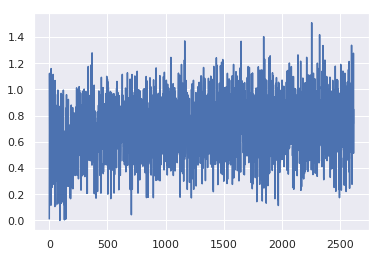

In [67]:
plt.plot(losses)

### Prepare for model evaluation

In [14]:
def to_q_array(qnet):
    states = np.empty((21, 10, 2))
    for p in range(21): states[p, :, 0] = p+1
    for d in range(10): states[:, d, 1] = d+1
    states = states.reshape((-1, 2))
    states_ = states_to_tensor(states)
    qs = qnet(states_).data.numpy().reshape(21, 10, 2)
    return qs

In [68]:
# load DP solution for model evaluation
f = np.load("result/dp.npz")
V_dp = f["V"]
Q_dp = f["Q"]
policy_dp = f["pi"]
mean_value_dp = f["mean_value"]
print(V_dp.shape, Q_dp.shape, policy_dp.shape)

def evaluate_qnet(qnet, plot=True, message=True):
    q_array = to_q_array(qnet)
    
    V = np.max(q_array, axis=-1)
    q_diff = q_array[:,:,1] - q_array[:,:,0]
    policy = np.argmax(q_array, axis=-1)

    if plot:
        # visualization
        fig, ax = plt.subplots(figsize=(6, 6))
        draw_heatmap(V, ax=ax, title="State Value")
        fig.tight_layout()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), sharex=True, sharey=True)
        draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
        draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
        fig.tight_layout()
    else:
        fig = None
    # mae of state values
    mae_v = np.mean(np.abs(V - V_dp))
    # mae of q values
    mae_q = np.mean(np.abs(q_array - Q_dp))
    # fraction of policy matched with the DP result
    frac = np.mean(policy == policy_dp)
    # mean policy value
    mean_value = mean_policy_value(policy, gamma=1.0)
    if message:
        print("MAE of state values      = %.5f" % (mae_v))
        print("MAE of action values     = %.5f" % (mae_q))
        print("Fraction of policy match = %.2f%%" % (100*frac))
        print("Expected player value    = %.5f" % (mean_value))
    return mae_v, mae_q, frac, mean_value, fig


(21, 10) (21, 10, 2) (21, 10)


MAE of state values      = 0.15515
MAE of action values     = 0.19620
Fraction of policy match = 72.86%
Expected player value    = 0.04493


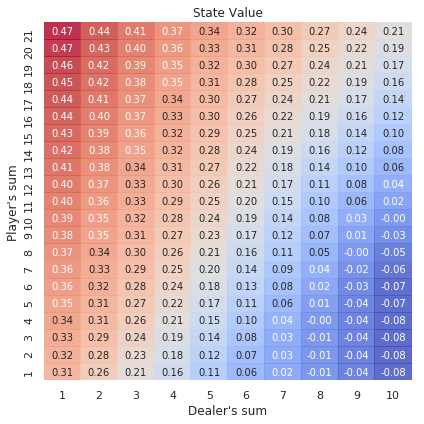

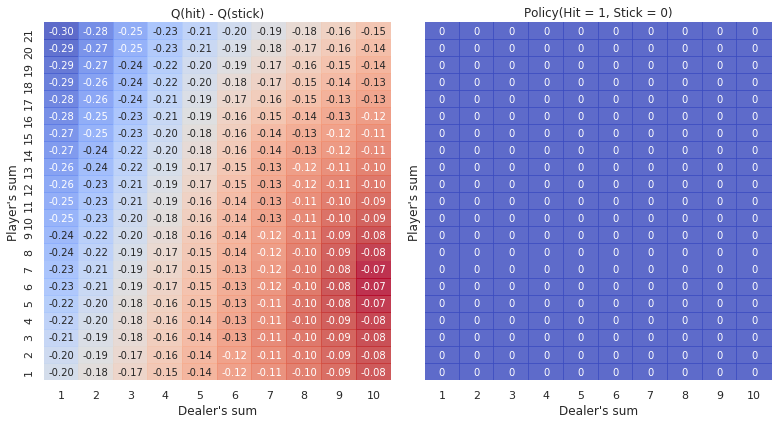

In [69]:
evaluate_qnet(qnet)
None

### Run the algorithm

We set $\epsilon$ to relatively high level (0.5). By doing so we observe more variety of state-action pairs quickly.  Notice that there is not much disadvantage of doing so in this game, since we can collect all state-action pairs efficiently even with complete random plays (and the randomness does not bias the estimate since we learn in off-policy manner).   This is not the case for problems like maze or cliff walk, where you need to choose near-optimal actions in order to experience all relevent states.  It may still slow down the convergence of the value, since we sample more for suboptimal actions.

In [82]:
qnet = QNetwork(hidden_size=8)
tnet = QNetwork(hidden_size=8)
tnet.load_state_dict(qnet.state_dict())
explore_policy = EpsilonGreedyPolicy(0.5)
replay_memory = ReplayBuffer(10**4)
optimizer = torch.optim.Adam(qnet.parameters(), lr=1e-4)
step_count = 0
mae_vs = []
mae_qs = []
fracs = []
values = []
losses = []

In [83]:
for i in range(10**5):
    qnet, tnet, step_count, losses_ = dqn_episode(qnet, tnet, optimizer, replay_memory, explore_policy, 
                                                  step_count=step_count, sync_cycle=100, batch_size=128)
    losses += losses_
    if (i+1) % 100 == 0:
        mae_v, mae_q, frac, value_, _ = evaluate_qnet(qnet, plot=False, message=False)
        mae_vs.append(mae_v)
        mae_qs.append(mae_q)
        fracs.append(frac)
        values.append(value_)
        if (i+1) % 2500 == 0:
            clear_output()
            print("Iter #%d" % (i+1))
            print("  MAE of state values             = %.4f" % mae_v)
            print("  MAE of state-action values      = %.4f" % mae_q)
            print("  Player mean value               = %.4f" % value_)
            print("  Fraction of policy match        = %.2f%%" % (100*frac))
            print("  Average of last 100 loss        = %.4f" % (sum(losses[-100:]) / 100.))

Iter #100000
  MAE of state values             = 0.0359
  MAE of state-action values      = 0.0397
  Player mean value               = 0.0620
  Fraction of policy match        = 96.19%
  Average of last 100 loss        = 0.6323


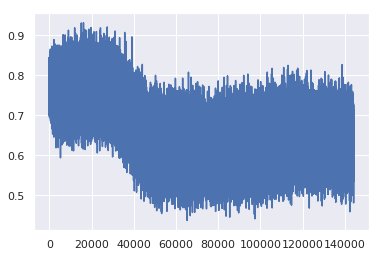

In [84]:
# losses at the initial phase is not meaningful, since the target is completely wrong.
# The target is never be "correct" in reinforcement learning; They get better along the iterations, hopefully.
plt.plot(losses[500:])
None

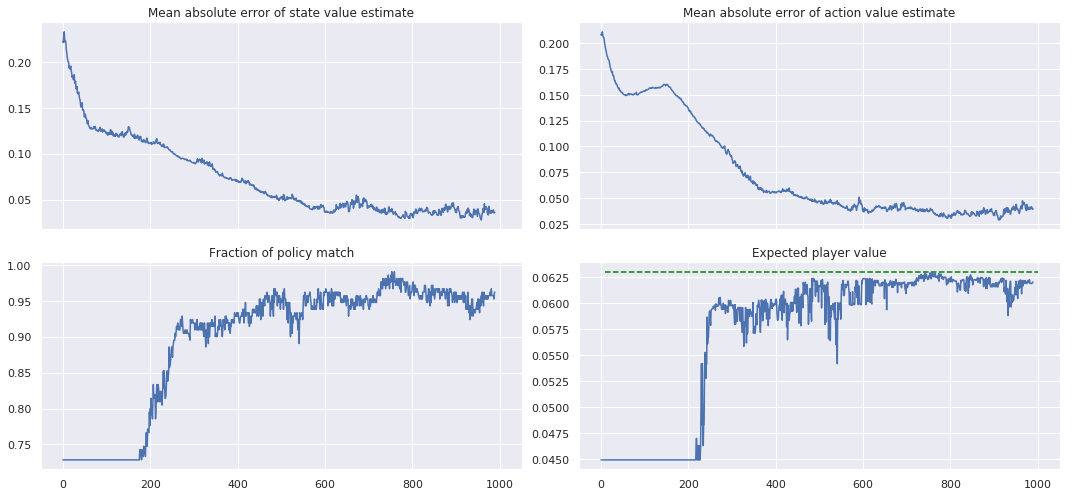

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), sharex=True)
axes[0][0].plot(mae_vs[10:])
axes[0][1].plot(mae_qs[10:])
axes[1][0].plot(fracs[10:])
axes[1][1].plot(values[10:])
axes[1][1].hlines(mean_value_dp, 10, len(values), linestyles="--", color="green")
axes[0][0].set_title("Mean absolute error of state value estimate")
axes[0][1].set_title("Mean absolute error of action value estimate")
axes[1][0].set_title("Fraction of policy match")
axes[1][1].set_title("Expected player value")
fig.tight_layout()
None

*Remark: Interestingly, the policy is stuck with "always-stick" policy for a while, until the model finally figures out that a bit of risk improves the payment.*

MAE of state values      = 0.03586
MAE of action values     = 0.03973
Fraction of policy match = 96.19%
Expected player value    = 0.06203


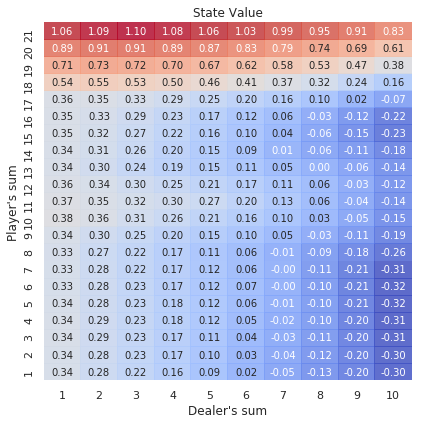

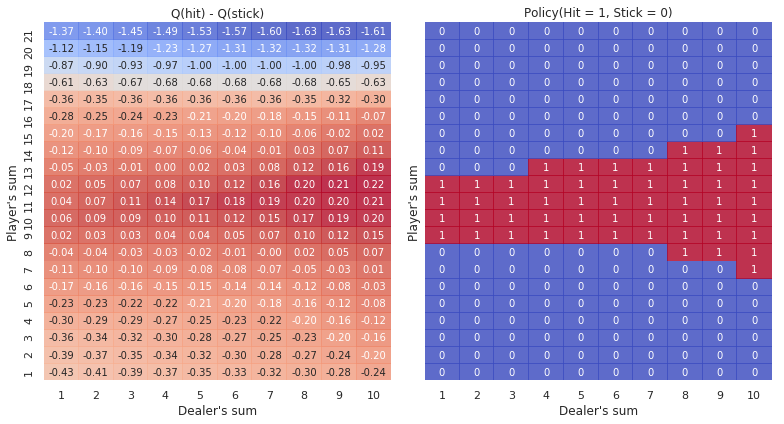

In [86]:
evaluate_qnet(qnet)
None

*Remark: We obtained near-optimal performance.  Perhaps thanks to experience replay, the learning process is much more stable than vanilla linear methods.*

## Implementation using keras-rl

In [29]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.optimizers import Adam
from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import EpsGreedyQPolicy
from rl.core import Processor

In [23]:
# Q function
# keras-rl takes states of a few consecutive time steps, i.e. 
# input shape = (timestep, states).
# This is useful for learning video inputs, where information from the
# previous frames are useful for guessing the next state.
def make_keras_q(hidden_size=10):
    inp = Input((1, 2))
    x = Flatten()(inp)
    x = Dense(hidden_size, activation="relu")(x)
    x = Dense(hidden_size, activation="relu")(x)
    x = Dense(2)(x)
    return Model(inp, x)
keras_q = make_keras_q(8)
keras_q.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 2)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________


In [31]:
# preprocess (normalize)
class Easy21Processor(Processor):
    def process_state_batch(self, batch):
        return batch / np.array([21., 11.])

In [32]:
# experience memory
memory = SequentialMemory(limit=10000, window_length=1)

In [33]:
dqn = DQNAgent(model=keras_q, nb_actions=2, memory=memory, processor=Easy21Processor(),
               nb_steps_warmup=128, batch_size=128,
               target_model_update=100, policy=EpsGreedyQPolicy(0.5))
dqn.compile(Adam(lr=1e-4))

In [34]:
dqn.fit(env, nb_steps=10**5, visualize=False, verbose=1)
None

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 711s 71ms/step - reward: 0.0078
7845 episodes - episode_reward: 0.010 [-1.000, 1.000] - loss: 0.380 - mean_q: 0.084 - mean_q_1: 0.084

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 765s 76ms/step - reward: -0.0062
7968 episodes - episode_reward: -0.008 [-1.000, 1.000] - loss: 0.382 - mean_q: 0.075 - mean_q_1: 0.075

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 764s 76ms/step - reward: 0.0041
7549 episodes - episode_reward: 0.005 [-1.000, 1.000] - loss: 0.366 - mean_q: 0.059 - mean_q_1: 0.059

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 711s 71ms/step - reward: -0.0049
6646 episodes - episode_reward: -0.007 [-1.000, 1.000] - loss: 0.328 - mean_q: 0.085 - mean_q_1: 0.085

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 715s 71ms/step - rew

In [35]:
def keras_to_q_array(keras_q):
    states = np.empty((21, 10, 2))
    for p in range(21): states[p, :, 0] = p+1
    for d in range(10): states[:, d, 1] = d+1
    states = states.reshape((-1, 1, 2))
    qs = dqn.compute_batch_q_values(states).reshape(21, 10, 2)
    return qs

def evaluate_keras_q(keras_q, plot=True, message=True):
    q_array = keras_to_q_array(qnet)
    
    V = np.max(q_array, axis=-1)
    q_diff = q_array[:,:,1] - q_array[:,:,0]
    policy = np.argmax(q_array, axis=-1)

    if plot:
        # visualization
        fig, ax = plt.subplots(figsize=(6, 6))
        draw_heatmap(V, ax=ax, title="State Value")
        fig.tight_layout()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), sharex=True, sharey=True)
        draw_heatmap(q_diff, ax=ax1, title="Q(hit) - Q(stick)")
        draw_heatmap(policy, ax=ax2, title="Policy(Hit = 1, Stick = 0)", fmt="d")
        fig.tight_layout()
    else:
        fig = None
    # mae of state values
    mae_v = np.mean(np.abs(V - V_dp))
    # mae of q values
    mae_q = np.mean(np.abs(q_array - Q_dp))
    # fraction of policy matched with the DP result
    frac = np.mean(policy == policy_dp)
    # mean policy value
    mean_value = mean_policy_value(policy, gamma=1.0)
    if message:
        print("MAE of state values      = %.5f" % (mae_v))
        print("MAE of action values     = %.5f" % (mae_q))
        print("Fraction of policy match = %.2f%%" % (100*frac))
        print("Expected player value    = %.5f" % (mean_value))
    return mae_v, mae_q, frac, mean_value, fig


MAE of state values      = 0.05507
MAE of action values     = 0.04860
Fraction of policy match = 92.86%
Expected player value    = 0.06084


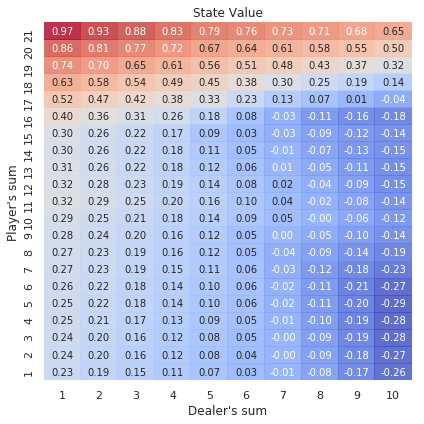

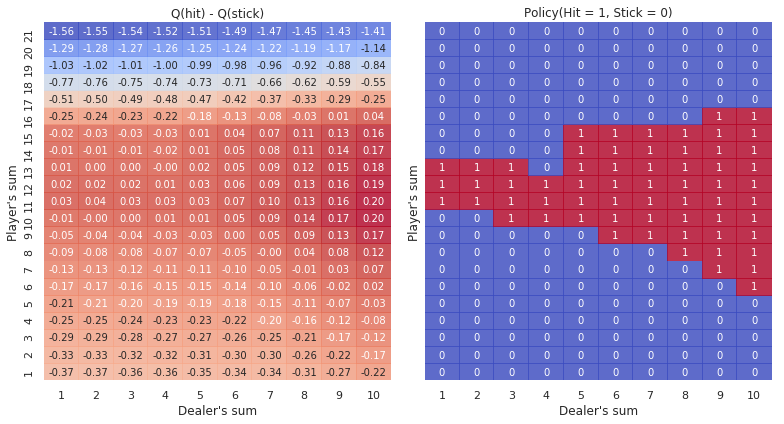

In [36]:
evaluate_keras_q(keras_q)
None

*Remark: We also obtained near-optimal performance.*